# Template Model Classification - Dataset X_train

In [1]:
#import semua library yg bakalan dipake di sini, biar rapih
#kalo kurang tambahin aja yaa wkwkwk

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, auc, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

# IMPORT & SPLIT DATASET 

In [2]:
df_train_x_train = pd.read_csv('processed_dataset/Train/processed_Train_X_train.csv')
df_test_x_train = pd.read_csv('processed_dataset/Test/processed_Test_X_train.csv')

In [3]:
df_train_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         10500 non-null  float64
 1   Customer_rating             10500 non-null  float64
 2   Cost_of_the_Product         10500 non-null  float64
 3   Prior_purchases             10500 non-null  float64
 4   Discount_offered            10500 non-null  float64
 5   Weight_in_gms               10500 non-null  float64
 6   Gender_encoded              10500 non-null  int64  
 7   Product_importance_encoded  10500 non-null  int64  
 8   Warehouse_block_A           10500 non-null  int64  
 9   Warehouse_block_B           10500 non-null  int64  
 10  Warehouse_block_C           10500 non-null  int64  
 11  Warehouse_block_D           10500 non-null  int64  
 12  Warehouse_block_F           10500 non-null  int64  
 13  Mode_of_Shipment_Flight     105

In [4]:
df_test_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_care_calls         8799 non-null   float64
 1   Customer_rating             8799 non-null   float64
 2   Cost_of_the_Product         8799 non-null   float64
 3   Prior_purchases             8799 non-null   float64
 4   Discount_offered            8799 non-null   float64
 5   Weight_in_gms               8799 non-null   float64
 6   Gender_encoded              8799 non-null   int64  
 7   Product_importance_encoded  8799 non-null   int64  
 8   Warehouse_block_A           8799 non-null   int64  
 9   Warehouse_block_B           8799 non-null   int64  
 10  Warehouse_block_C           8799 non-null   int64  
 11  Warehouse_block_D           8799 non-null   int64  
 12  Warehouse_block_F           8799 non-null   int64  
 13  Mode_of_Shipment_Flight     8799 

In [5]:
#split X dan Y 
#moga2 split train sama testnya bener ya KWKWKWKWK

X_train = df_train_x_train.drop('arrived_late', axis = 1)
y_train = df_train_x_train['arrived_late']
X_test = df_test_x_train.drop('arrived_late', axis = 1)
y_test = df_test_x_train['arrived_late']

# FUNCTIONS

In [6]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    
    print("AUC (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("AUC (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
#     print("AUC (test-label): %.2f" % roc_auc_score(y_test, y_pred))
#     print("AUC (train-label): %.2f" % roc_auc_score(y_train, y_pred_train))
    print('\n------------------------\n')
    print(classification_report(y_test, y_pred))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')
    
#feature importance untuk SVM
def feature_plot(classifier, feature_names, top_features=8):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    plt.figure(figsize=(18, 7))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 0 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
    plt.show()

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [7]:
def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

    plt.plot(C, train_scores, label='Train')
    plt.plot(C, test_scores, label='Test')
    plt.legend()
    plt.show()

# AdaBoost

In [10]:
ada = AdaBoostClassifier()

In [11]:
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
eval_classification(ada)

Accuracy (Test Set): 0.69
Precision (Test Set): 0.98
Recall (Test Set): 0.48
F1-Score (Test Set): 0.65
AUC (test-proba): 0.76
AUC (train-proba): 0.76

------------------------

              precision    recall  f1-score   support

           0       0.56      0.98      0.72      3549
           1       0.98      0.48      0.65      5250

    accuracy                           0.69      8799
   macro avg       0.77      0.73      0.68      8799
weighted avg       0.81      0.69      0.67      8799



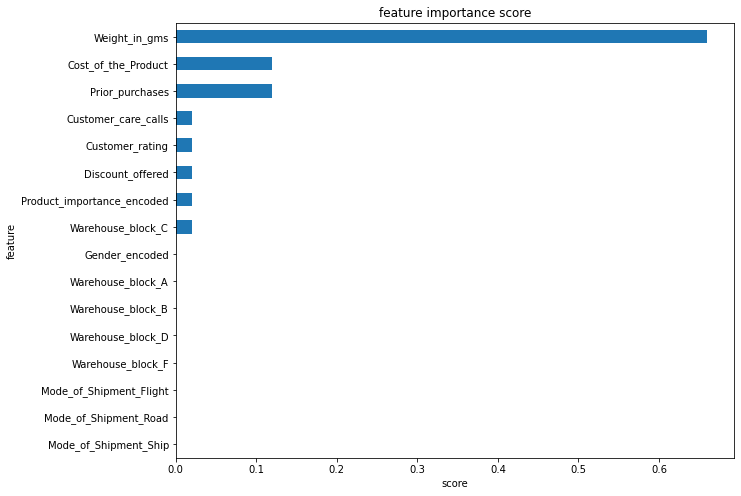

In [12]:
show_feature_importance(ada)

# Logistic Regression (Riyan)

In [14]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
eval_classification(model)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.83
Recall (Test Set): 0.52
F1-Score (Test Set): 0.64
AUC (test-proba): 0.72
AUC (train-proba): 0.72

------------------------

              precision    recall  f1-score   support

           0       0.54      0.84      0.66      3549
           1       0.83      0.52      0.64      5250

    accuracy                           0.65      8799
   macro avg       0.69      0.68      0.65      8799
weighted avg       0.71      0.65      0.65      8799



In [15]:
show_feature_importance(model)
# gak bisa pake show_feature_importance, temen" ada opsi lain?

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

# Decision Tree (Arsya)

In [16]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)
eval_classification(dt)

Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC (test-proba): 1.00
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3549
           1       1.00      1.00      1.00      5250

    accuracy                           1.00      8799
   macro avg       1.00      1.00      1.00      8799
weighted avg       1.00      1.00      1.00      8799



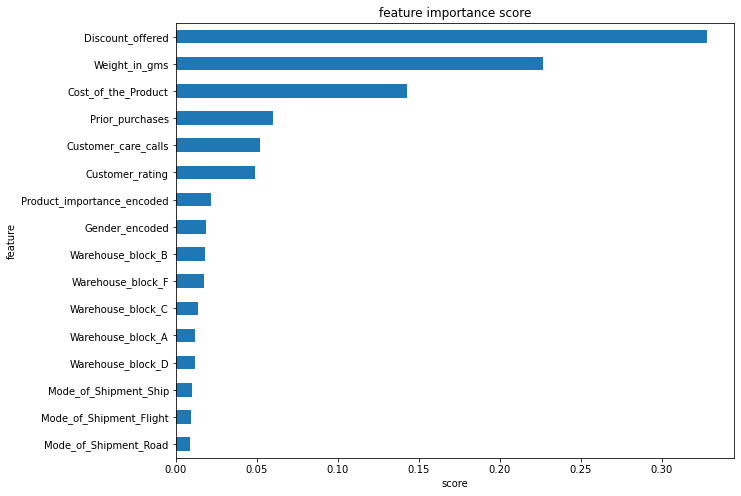

In [17]:
show_feature_importance(dt)

# Random Forest (Edo)

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
eval_classification(rf)

Accuracy (Test Set): 1.00
Precision (Test Set): 1.00
Recall (Test Set): 1.00
F1-Score (Test Set): 1.00
AUC (test-proba): 1.00
AUC (train-proba): 1.00

------------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3549
           1       1.00      1.00      1.00      5250

    accuracy                           1.00      8799
   macro avg       1.00      1.00      1.00      8799
weighted avg       1.00      1.00      1.00      8799



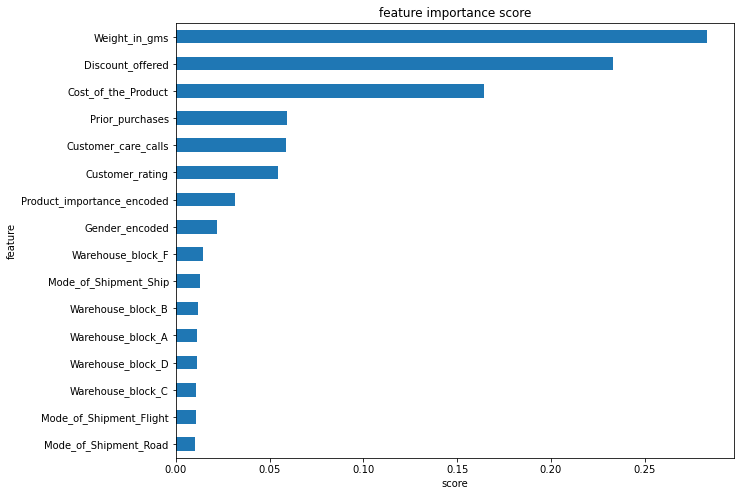

In [19]:
show_feature_importance(rf)

# Support Vector Classification - SVM (Afif)

In [21]:
svc = SVC(kernel='linear',probability=True)
svc.fit(X_train,y_train)


y_pred = svc.predict(X_test)
eval_classification(svc)

Accuracy (Test Set): 0.65
Precision (Test Set): 0.99
Recall (Test Set): 0.42
F1-Score (Test Set): 0.59
AUC (test-proba): 0.72
AUC (train-proba): 0.72

------------------------

              precision    recall  f1-score   support

           0       0.53      0.99      0.69      3549
           1       0.99      0.42      0.59      5250

    accuracy                           0.65      8799
   macro avg       0.76      0.70      0.64      8799
weighted avg       0.80      0.65      0.63      8799



Model dinilai telah mencapai best-fit, karena memiliki nilai AUC pada test & train yang tidak berbeda.

Team mencari model yang dapat mengurangi nilai yang diprediksi akan 'on time' namun aktualnya telat. Hal tersebut dapat dilihat dari nilai precision terhadap '0' atau nilai recall terhadap '1'.
Diketahui bahwa nilai precision terhadap '0' adalah 0.53 dan precision 0.42

In [22]:
features_names= X_train.columns.values
features_names

array(['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered', 'Weight_in_gms',
       'Gender_encoded', 'Product_importance_encoded',
       'Warehouse_block_A', 'Warehouse_block_B', 'Warehouse_block_C',
       'Warehouse_block_D', 'Warehouse_block_F',
       'Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road',
       'Mode_of_Shipment_Ship'], dtype=object)

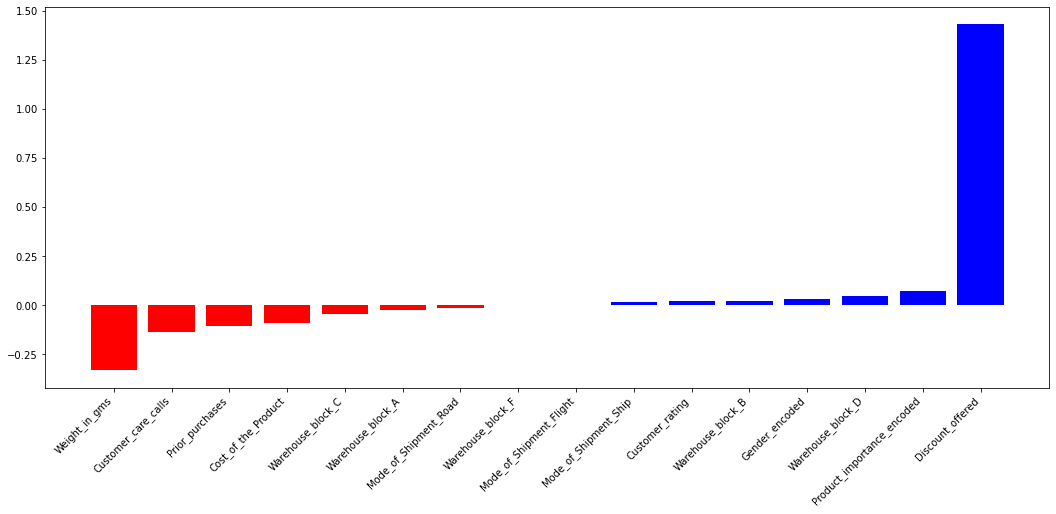

In [23]:
feature_plot(svc, features_names)

dalam model menggunakan algoritma SVC, features discount_offered memiliki koefisien positive paling bermakna terhadap target. 

# K-Nearest Neighbor

# XGBoost (Agas)

In [29]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

eval_classification(xgb)

Accuracy (Test Set): 0.87
Precision (Test Set): 0.98
Recall (Test Set): 0.79
F1-Score (Test Set): 0.88
AUC (test-proba): 0.97
AUC (train-proba): 0.98

------------------------

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      3549
           1       0.98      0.79      0.88      5250

    accuracy                           0.87      8799
   macro avg       0.87      0.89      0.87      8799
weighted avg       0.89      0.87      0.87      8799



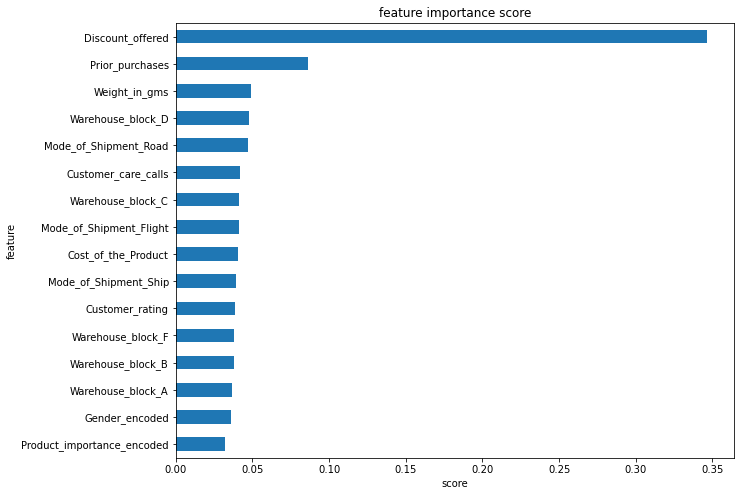

In [30]:
show_feature_importance(xgb)